# Lecture 14

The goal here is to do more with the Projective Geometry classes. 

* We add the canonical duality, swapping points and lines.
* One basis thing we want to do is be able to draw lines. For this we introduce a `PlotBox` class.
* We illustrate Pappus' Theorem.
* We will look at a result that builds off of Pappus' Theorem: Steiner's Theorems.
* We will also look a bit at a construction of a fractal curve obtained by iterating Pappus' theorem. This construction is due to Rich Schwartz.

Projective geometry is a bit of an arbitrary math topic. But, I hope that this illustrates how programming can allow you to explore mathematical concepts, and push from basic observations to deeper and more complex mathematics.

## The original classes

These are classes from the homework with a few minor changes:

* Added a `euc()` method to `ProjectivePoint` which returns the vector of Euclidean coordinates.
* Changed constructors to normalize the last non-zero coordinate to be one. This prevents some drift in repeated calculations (which bogs down calculations).


In [1]:
class ProjectivePlane:
    def __init__(self, field):
        self._field = field
        self._vector_space = VectorSpace(field, 3)

    def field(self):
        'Return the field over which this projective plane is defined.'
        return self._field

    def vector_space(self):
        'Return the vector space F^3 where F is the base field.'
        return self._vector_space

    def plane(self):
        'Return the ProjectivePlane containing this point'
        return self._plane

    def __repr__(self):
        return f'ProjectivePlane({repr(self._field)})'

    def __str__(self):
        return f'Projective plane over {str(self._field)}'

    def __eq__(self, other):
        if type(self) != type(other):
            return False
        # Now we know the objects are both ProjectivePlanes
        return self.field() == other.field()

    def __hash__(self):
        # Return the hash of the pair consisting of 'ProjectivePlane' and the field:
        return hash( (ProjectivePlane, self._field()) )

    def __contains__(self, item):
        # Currently the only thing in a ProjectivePlane is a ProjectivePoint
        # Later we will check other types (like Lines).
        if isinstance(item, ProjectivePoint):
            return self == item.plane()
        if isinstance(item, ProjectiveLine):
            return self == item.plane()
        return False

    def point(self, v):
        'Construct a ProjectivePoint in this plane representing [v].'
        return ProjectivePoint(self, v)

    def line(self, n):
        'Construct a ProjectiveLine in this plane using the provided normal vector.'
        return ProjectiveLine(self, n)

In [2]:
class ProjectivePoint:

    def __init__(self, plane, v):
        'Construct a point from a ProjectivePlane and a 3-dimensional vector.'

        # Raise an error if ProjectivePlane is not a ProjectivePlane
        if not isinstance(plane, ProjectivePlane):
            # Raise a TypeError which indicates that the parameter was the wrong type
            raise TypeError('The parameter plane must be a ProjectivePlane')

        self._plane = plane # Store the projective plane
        
        v = self._plane.vector_space()(v) # Convert v into the vector space.

        if v == self._plane.vector_space().zero():
            # Raise a ValueError indicating the vecotr is unacceptable
            raise ValueError('The vector can not be zero')

        # NEW NORMALIZATION:
        if v[2] != 0:
            v /= v[2]
        elif v[1] != 0:
            v /= v[1]
        else:
            v /= v[0]
        
        v.set_immutable()   # Make it so the vector cannot be changed.
        self._v = v         # Store the vector.

    def vector(self):
        r'Return a vector representing this point.'
        return self._v
    
    def is_infinite(self):
        'Return True if this point is on the line at infinity in the projective plane.'
        return self._v[2] == 0
    
    def plane(self):
        'Return the ProjectivePlane containing this point'
        return self._plane

    def x(self):
        'Return the x-coordinate or infinity if the point lies at infinity.'
        if self.is_infinite():
            return Infinity
        return self._v[0] / self._v[2]

    def y(self):
        'Return the y-coordinate or infinity if the point lies at infinity.'
        if self.is_infinite():
            return Infinity
        return self._v[1] / self._v[2]

    # NEW METHOD:
    def euc(self):
        'Return a vector in R^2 representing the point'
        return vector(self.plane().field(), (self.x(), self.y()))
    
    def __repr__(self):
        return f'ProjectivePoint({repr(self._plane)}, {repr(self._v)})'

    def __str__(self):
        if self.is_infinite():
            if self._v[0] != 0:
                m = self._v[1] / self._v[0]
                return f'common point at infinity of lines of slope {m}'
            else:
                return 'common point at infinity of vertical lines'
        return f'({self.x()}, {self.y()})'

    def __eq__(self, other):
        if not isinstance(other, ProjectivePoint):
            return False
        if self._v[0] != 0:
            ratio = other._v[0] / self._v[0]
        elif self._v[1] != 0:
            ratio = other._v[1] / self._v[1]
        else:
            # It is not allowed for all 3 entries to be zero
            ratio = other._v[2] / self._v[2]
        return ratio*self._v == other._v

    def __hash__(self):
        # cv will be the canonical representative of the equivalence class of self._v
        if self._v[0] != 0:
            cv = (1/self._v[0]) * self._v
        elif self._v[1] != 0:
            cv = (1/self._v[1]) * self._v
        else:
            cv = (1/self._v[2]) * self._v

        # So we can hash cv, we set it to be immutable:
        cv.set_immutable()

        return hash((ProjectivePoint, cv))

    def join(self, other_point):
        'Return the line joining the two points'
        return self.plane().line(self.vector().cross_product(other_point.vector()))

In [3]:
class ProjectiveLine:

    def __init__(self, plane, n):
        'Construct a line from a ProjectivePlane and a 3-dimensional normal vector.'

        # Raise an error if ProjectivePlane is not a ProjectivePlane
        if not isinstance(plane, ProjectivePlane):
            # Raise a TypeError which indicates that the parameter was the wrong type
            raise TypeError('The parameter plane must be a ProjectivePlane')

        self._plane = plane # Store the projective plane
        
        n = self._plane.vector_space()(n) # Convert v into the vector space.

        if n == self._plane.vector_space().zero():
            # Raise a ValueError indicating the vecotr is unacceptable
            raise ValueError('The vector can not be zero')

        # NEW NORMALIZATION:
        if n[2] != 0:
            n /= n[2]
        elif n[1] != 0:
            n /= n[1]
        else:
            n /= n[0]
        
        n.set_immutable()   # Make it so the vector cannot be changed.
        self._n = n         # Store the vector.

    def plane(self):
        'Return the plane that contains this line'
        return self._plane

    def normal(self):
        'Return a normal vector to the plane through the origin that represents this line.'
        return self._n

    def is_at_infinity(self):
        'Return True if this line is at infinity, False otherwise.'
        return self._n[0]==0 and self._n[1]==0

    def slope(self):
        '''Return the slope of the line (possibly `Infinite`).

        Raises a ValueError if the line is the line at infinity.'''
        if self.is_at_infinity():
            raise ValueError('The line at infinity has no slope.')
        elif self._n[1] == 0:
            return Infinity
        else:
            return -self._n[0] / self._n[1]

    def y_intercept(self):
        '''Return the y-intercept of the line (possibly `Infinity`).

        Raises a ValueError if the line is the y-axis.'''
        try:
            return -self._n[2] / self._n[1]
        except ZeroDivisionError:
            # We know self._n[1] == 0
            if self._n[2] == 0:
                # The line is the y-axis
                raise ValueError('The y-axis has no y-intercept.')
            else:
                # The y-intercept is at infinity.
                return Infinity

    def x_intercept(self):
        '''Return the x-intercept of the line (possibly `Infinity`).

        Raises a ValueError if the line is the x-axis.'''
        try:
            return -self._n[2] / self._n[0]
        except ZeroDivisionError:
            # We know self._n[1] == 0
            if self._n[2] == 0:
                # The line is the x-axis
                raise ValueError('The x-axis has no x-intercept.')
            else:
                # The x-intercept is at infinity.
                return Infinity

    def __repr__(self):
        return f'ProjectiveLine({self._n})'

    def __str__(self):
        if self.is_at_infinity():
            return 'the line at infinity'
        m = self.slope()
        if m == Infinity:
            a = self.x_intercept()
            return f'the vertical line x={a}'
        b = self.y_intercept()
        if m == 0:
            return f'the horizontal line y={b}'
        else:
            if b >=0:
                return f'the line y={m}*x+{b}'
            else:
                # b should begin with a negative sign.
                return f'the line y={m}*x{b}'

    def __eq__(self, other):
        if not isinstance(other, ProjectiveLine):
            return False
        if self._n[0] != 0:
            ratio = other._n[0] / self._n[0]
        elif self._n[1] != 0:
            ratio = other._n[1] / self._n[1]
        else:
            # It is not allowed for all 3 entries to be zero
            ratio = other._n[2] / self._n[2]
        return ratio*self._n == other._n

    def __hash__(self):
        # cn will be the canonical representative of the equivalence class of self._n
        if self._n[0] != 0:
            cn = (1/self._n[0]) * self._n
        elif self._n[1] != 0:
            cn = (1/self._n[1]) * self._n
        else:
            cn = (1/self._n[2]) * self._n

        # So we can hash cn, we set it to be immutable:
        cn.set_immutable()

        return hash((ProjectiveLine, cn))

    def __contains__(self, item):
        if not isinstance(item, ProjectivePoint):
            return False
        return self._n * item.vector() == 0

    def intersect(self, other_line):
        'Return the common point shared by two lines.'
        return self.plane().point(self._n.cross_product(other_line.normal()))

# Duality

In [4]:
def dual(self):
    return self.plane().line(self.vector())

In [5]:
ProjectivePoint.dual = dual

In [6]:
plane = ProjectivePlane(QQ)
pt = plane.point([1,1,1])
pt.dual()

ProjectiveLine((1, 1, 1))

In [7]:
def dual(self):
    return self.plane().point(self.normal())
ProjectiveLine.dual = dual

In [8]:
l = plane.line((1,2,3))
l.dual()

ProjectivePoint(ProjectivePlane(Rational Field), (1/3, 2/3, 1))

In [9]:
l.dual().dual() == l

True

## Drawing points

We had some discussion of points and labels during [Lecture 9](http://wphooper.com/teaching/2024-fall-sage/docs/Lecture%209.html). This lecture also had a discussion of using the `|` operator to merge dictionaries. In fact that lecture had the code:

```python
def point_with_label(v, label, point_opts = {}, label_opts = {}):
    point_defaults = {'color': 'black', 'size': '20'}
    point_kwds = point_defaults | point_opts
    plt = point([v], **point_kwds)
    label_defaults = {'horizontal_alignment': 'right', 'vertical_alignment': 'top'}
    label_kwds = label_defaults | label_opts
    plt += text(label, v, **label_kwds)
    return plt
```

We will modify this code to plot points in the projective plane.

In [10]:
# To be added to the ProjectivePoint class
def plot(self, label=None, point_opts = dict(), label_opts = dict()):
    if self.is_infinite():
        raise ValueError('Can not plot a point that is at infinity!')
    point_defaults = dict(color='black', size='20', zorder=8)
    point_kwds = point_defaults | point_opts
    plt = point([(self.x(), self.y())], **point_kwds)
    if label:
        label_defaults = dict(color='black', horizontal_alignment='right', vertical_alignment='top', zorder=10)
        label_kwds = label_defaults | label_opts
        plt += text(label, (self.x(), self.y()), **label_kwds)
    return plt
ProjectivePoint.plot = plot

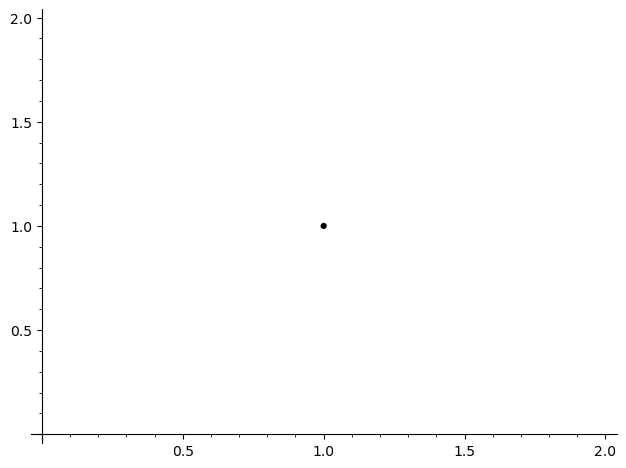

In [11]:
# We have to construct a new point to have access to the plot function.
pt = plane.point([1,1,1])
pt.plot()

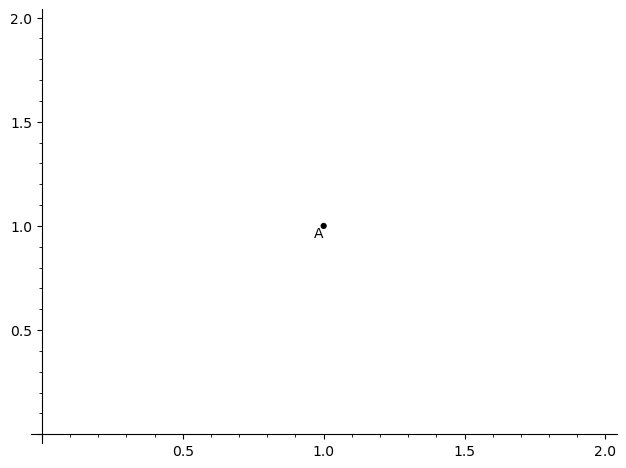

In [12]:
# We have to construct a new point to have access to the plot function.
pt = plane.point([1,1,1])
pt.plot(label='A')

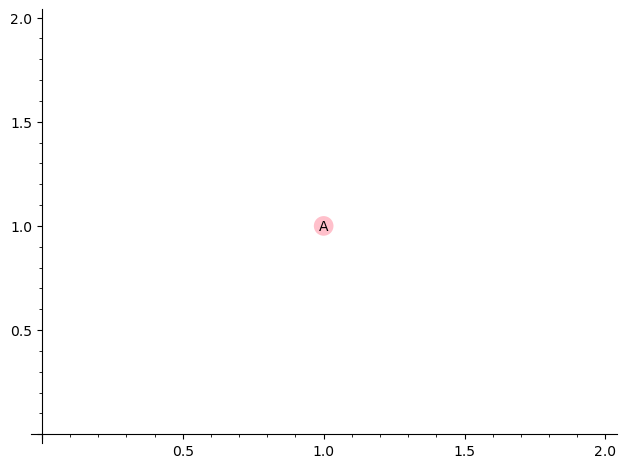

In [13]:
# Checking that we can override default values:
pt = plane.point([1,1,1])
plt = pt.plot(label='A', 
              point_opts=dict(size=200, color='pink'), 
              label_opts=dict(horizontal_alignment='center', vertical_alignment='center'))
plt

## A class for drawing lines

We want to be able to draw constructions, which include lines. One difficulty is that line are infinite. So we need to crop them. We'll create a class to handle plotting them. First observe that a plot has a bounding box associated to it. For example:

In [18]:
data = plt.get_minmax_data()
data

{'xmin': 0.0, 'xmax': 2.0, 'ymin': 0.0, 'ymax': 2.0}

In [19]:
data.keys()

dict_keys(['xmin', 'xmax', 'ymin', 'ymax'])

Each of these is associated to a line: For example `xmin = 0` represents the line $x=0$.

In [20]:
class PlotBox:
    def __init__(self, plt_or_dict):
        if isinstance(plt_or_dict, Graphics) or isinstance(plt_or_dict, PlotBox):
            self._minmax_data = plt_or_dict.get_minmax_data()
        else:
            self._minmax_data = dict(plt_or_dict)
        if set(self._minmax_data.keys()) != {'xmin', 'xmax', 'ymin', 'ymax'}:
            raise ValueError("plt_or_dict should be a Graphics object or a dictionary with key set {'xmin', 'xmax', 'ymin', 'ymax'}")
        self._plane = ProjectivePlane(RDF) # We don't care about exact arithmetic.
        self._setup_lines()

    def get_minmax_data(self):
        return self._minmax_data
    
    def _setup_lines(self):
        self._lines = {}
        x = self._minmax_data['xmax']
        self._lines['xmax'] = self._plane.point([x,0,1]).join(self._plane.point([x,1,1]))
        x = self._minmax_data['xmin']
        self._lines['xmix'] = self._plane.point([x,0,1]).join(self._plane.point([x,1,1]))
        y = self._minmax_data['ymax']
        self._lines['ymax'] = self._plane.point([0,y,1]).join(self._plane.point([1,y,1]))
        y = self._minmax_data['ymin']
        self._lines['ymin'] = self._plane.point([0,y,1]).join(self._plane.point([1,y,1]))

    def __contains__(self, point):
        if not isinstance(point, ProjectivePoint):
            raise ValueError('The only things in a PlotBox are ProjectivePoints.')
        if point.is_infinite():
            return False
        tol = 10^-5 # Because we are doing floating point arithmetic, we want some leeway in containment tests
        if point.x() < self._minmax_data['xmin'] - tol:
            return False
        if point.x() > self._minmax_data['xmax'] + tol:
            return False
        if point.y() < self._minmax_data['ymin'] - tol:
            return False
        if point.y() > self._minmax_data['ymax'] + tol:
            return False
        return True
    
    def center(self):
        r'''Return the center of the box'''
        return vector(RDF, ( (self._minmax_data['xmin'] + self._minmax_data['xmax']) / 2,
                             (self._minmax_data['ymin'] + self._minmax_data['ymax']) / 2 ))

    def plot_line(self, line, label=None, line_opts = dict(), label_opts = dict()):
        # Convert the line into our RDF plane:
        line = self._plane.line(line.normal())
        pts = set()
        for key,boundary_line in self._lines.items():
            try:
                point = line.intersect(boundary_line)
                if point in self:
                    pts.add(point)
            except ValueError:
                # Probably caused by the two lines coinciding
                pass
        # Convert the points to vectors in the plane:
        pts = [vector(RDF, pt.euc()) for pt in pts]
        if len(pts) >= 3:
            # If we did exact arithmetic, there could be only two points here...
            # We will find the two that are farthest apart.
            max_dist = RDF.zero()
            farthest_pair = None
            for i in range(len(pts)):
                vi = pts[i]
                for j in range(i+1, len(pts)):
                    vj = pts[j]
                    norm = (vi-vj).norm()
                    if norm > max_dist:
                        farthest_pair=[vi, vj]
                        max_dist = norm
            assert farthest_pair, f'It should not be that farthest_pair is still None!, {line}, {self.get_minmax_data()}'
            pts = farthest_pair
            # Now there are two points in pts.
        if len(pts)==2:
            line_defaults = dict(color='blue', zorder=0)
            line_kwds = line_defaults | line_opts
            plt = line2d(pts, **line_kwds)
            midpt = 1/2*(pts[0] + pts[1])
            if label:
                label_defaults = dict(color='black', horizontal_alignment='right', vertical_alignment='top', zorder=2)
                label_kwds = label_defaults | label_opts
                plt += text(label, midpt, **label_kwds)
            return plt
        return None # doesn't intersect the box in a line segment.

    def __str__(self):
        return f'PlotBox({self._minmax_data})'

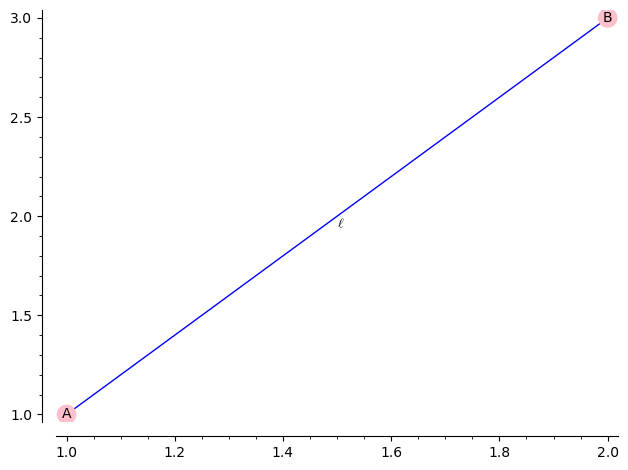

In [21]:
# Checking that we can override default values:
pt_A = plane.point([1,1,1])
plt = pt_A.plot(label='A', 
                point_opts=dict(size=200, color='pink'), 
                label_opts=dict(horizontal_alignment='center', vertical_alignment='center'))
pt_B = plane.point([2,3,1])
plt += pt_B.plot(label='B', 
                point_opts=dict(size=200, color='pink'), 
                label_opts=dict(horizontal_alignment='center', vertical_alignment='center'))
box = PlotBox(plt)
line = pt_A.join(pt_B)
plt += box.plot_line(line, label=r'$\ell$', label_opts=dict(horizontal_alignment='left'))
plt

In [22]:
# For plotting a line
def plot(self, plt_or_box, label=None, line_opts = dict(), label_opts = dict()):
    if isinstance(plt_or_box, PlotBox):
        box = plt_or_box
    else:
        box = PlotBox(plt_or_box)
    return box.plot_line(self, label=label, line_opts=line_opts, label_opts=label_opts)
ProjectiveLine.plot = plot

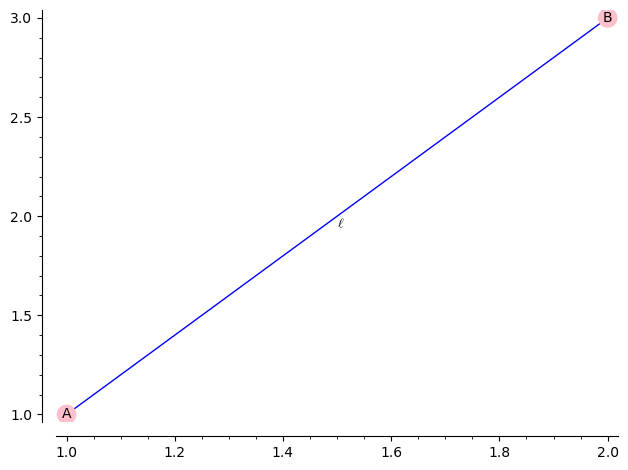

In [23]:
pt_A = plane.point([1,1,1])
plt = pt_A.plot(label='A', 
                point_opts=dict(size=200, color='pink'), 
                label_opts=dict(horizontal_alignment='center', vertical_alignment='center'))
pt_B = plane.point([2,3,1])
plt += pt_B.plot(label='B', 
                point_opts=dict(size=200, color='pink'), 
                label_opts=dict(horizontal_alignment='center', vertical_alignment='center'))
line = pt_A.join(pt_B)
plt += line.plot(plt, label=r'$\ell$', label_opts=dict(horizontal_alignment='left'))
plt

### Pappus' Theorem

Given colinear points $P_0, P_1, P_2$ and $Q_0, Q_1, Q_2$, Pappus' Theorem says that the three points
$$R_0 = \overline{P_0 Q_1} \cap \overline{P_1 Q_0}, \quad 
R_1 = \overline{P_0 Q_2} \cap \overline{P_2 Q_0}, \quad
R_2 = \overline{P_1 Q_2} \cap \overline{P_2 Q_1}$$
are also colinear.

In [24]:
def construct_triple(p0, p2, t):
    p1 = p0.plane().point([(1-t)*p0.x()+t*p2.x(), (1-t)*p0.y()+t*p2.y(), 1])
    return (p0, p1, p2)

In [25]:
plane = ProjectivePlane(QQ)
p = construct_triple(plane.point([0,1/2,1]), plane.point([3,1,1]), 2/3)
p

(ProjectivePoint(ProjectivePlane(Rational Field), (0, 1/2, 1)),
 ProjectivePoint(ProjectivePlane(Rational Field), (2, 5/6, 1)),
 ProjectivePoint(ProjectivePlane(Rational Field), (3, 1, 1)))

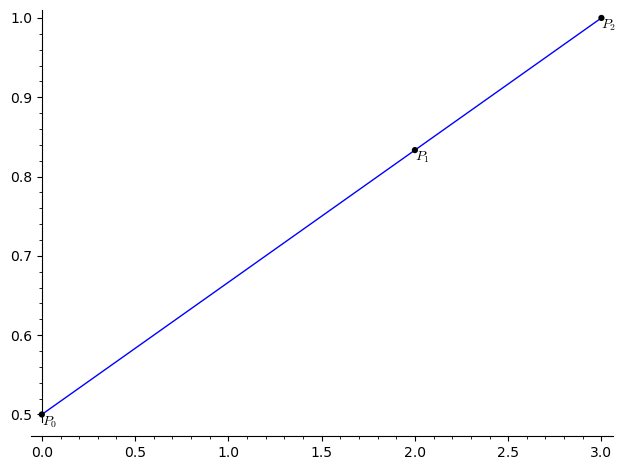

In [26]:
def draw_triple(p, letter=None, points=True, line=True, box = 'connect', point_opts={}, label_opts={}, line_opts={}):
    plt = None
    if points or not box:
        for i in range(3):
            if letter:
                plt2 = p[i].plot(label=fr'${letter}_{i}$', point_opts=point_opts, label_opts=label_opts)
            else:
                plt2 = p[i].plot(point_opts=point_opts)
            if plt:
                plt += plt2
            else:
                plt = plt2
        if not box:
            box = PlotBox(plt)
            if not points:
                plt = None
    if line:
        if box == 'connect':
            plt2 = line2d([p[0].euc(), p[2].euc()], **line_opts)
        else:
            line = p[0].join(p[2])
            plt2 = line.plot(box, line_opts = line_opts)
        if plt:
            plt += plt2
        else:
            plt = plt2
    return plt
draw_triple(p, 'P', label_opts=dict(horizontal_alignment='left'))

In [27]:
q = construct_triple(plane.point([-1,3,1]), plane.point([3,3,1]), 2/5)
q

(ProjectivePoint(ProjectivePlane(Rational Field), (-1, 3, 1)),
 ProjectivePoint(ProjectivePlane(Rational Field), (3/5, 3, 1)),
 ProjectivePoint(ProjectivePlane(Rational Field), (3, 3, 1)))

In [28]:
def pappus(p, q):
    r = (
        p[0].join(q[1]).intersect(p[1].join(q[0])),
        p[0].join(q[2]).intersect(p[2].join(q[0])),
        p[1].join(q[2]).intersect(p[2].join(q[1])),
    )
    return r

In [29]:
r = pappus(p, q)
r

(ProjectivePoint(ProjectivePlane(Rational Field), (4/11, 133/66, 1)),
 ProjectivePoint(ProjectivePlane(Rational Field), (3/2, 7/4, 1)),
 ProjectivePoint(ProjectivePlane(Rational Field), (7/3, 14/9, 1)))

In [30]:
def draw_pappus(p, q, box=None):
    r = pappus(p,q)
    if not box:
        plt1 = draw_triple(p, 'P', line=False)
        plt1 += draw_triple(q, 'Q', line=False)
        plt1 += draw_triple(r, 'R', line=False)
        box = PlotBox(plt1)
    plt = draw_triple(p, 'P', box=box)
    plt += draw_triple(q, 'Q', box=box)
    plt += draw_triple(r, 'R', box=box) 
    
    for i in range(3):
        for j in range(3):
            if i!=j:
                line = p[i].join(q[j])
                plt2 = line.plot(box, line_opts = dict(color='red'))
                if plt2:
                    plt += plt2
    return plt

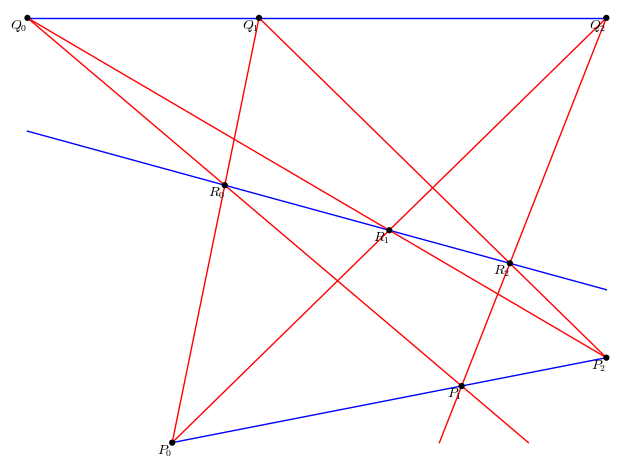

In [31]:
show(draw_pappus(p, q), axes=False)

## Permutation groups

We will consider the action of the permutation group $S_3$, which acts on sets of three elements. We can generate $S_3$ with two generators: An order three element that we are calling `perm3` below, and an order two element that we are calling `perm2`.

In [35]:
perm3 = Permutation('(1,2,3)')
perm3

[2, 3, 1]

In [36]:
for i in range(1, 4):
    print(f'perm3({i}) = {perm3(i)}')

perm3(1) = 2
perm3(2) = 3
perm3(3) = 1


In [37]:
l = ['a', 'b', 'c']
perm3.action(l)

['b', 'c', 'a']

In [38]:
perm2 = Permutation('(1,2)(3)')
perm2

[2, 1, 3]

In [39]:
perm2.action(l)

['b', 'a', 'c']

In [40]:
(perm2^2).is_one()

True

In [41]:
S_3 = perm2.parent()
S_3

Standard permutations of 3

In [42]:
for perm in perm2.parent():
    print(perm)

[1, 2, 3]
[1, 3, 2]
[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[3, 2, 1]


## Steiner's Theorem 1

Pappus's Theorem depends on choosing a correspondence between two triples of points $p=(P_0, P_1, P_2)$ and $q=(Q_0, Q_1, Q_2)$. By default we use the correspondence $P_i \leftrightarrow Q_i$. Points for the new triple are obtained by $\overline{P_i Q_j} \cap \overline{P_k Q_\ell}$ where neither $P_i \leftrightarrow Q_j$ nor $P_k \leftrightarrow Q_\ell$. We can change the correspondence by acting by a permutation of one of the triples (say $q$). Acting on the other triple would result in the same triple.

So we can construct six new triples (one for each element of $S_3$).

**Steiner's Theorem:** The lines produced by the six possible correspondences between points in triples $p$ and $q$ are concurent in threes.

In [43]:
def plotSteiner(p, q):
    # First pass we just plot points
    plt = draw_triple(p, 'P', line=False)
    plt += draw_triple(q, 'Q', line=False)
    perm3 = Permutation('(1,2,3)')
    even_perms = [perm3^i for i in range(3)]
    for perm in even_perms:
        alt_q = perm.action(q)
        r = pappus(p, alt_q)
        plt += draw_triple(r, line=False)
    box = PlotBox(plt)
    plt = draw_triple(p, 'P', box=box)
    plt += draw_triple(q, 'Q', box=box)
    perm3 = Permutation('(1,2,3)')
    even_perms = [perm3^i for i in range(3)]
    for perm in even_perms:
        alt_q = perm.action(q)
        r = pappus(p, alt_q)
        plt += draw_triple(r, box=box, line_opts=dict(color='red'))
    return plt

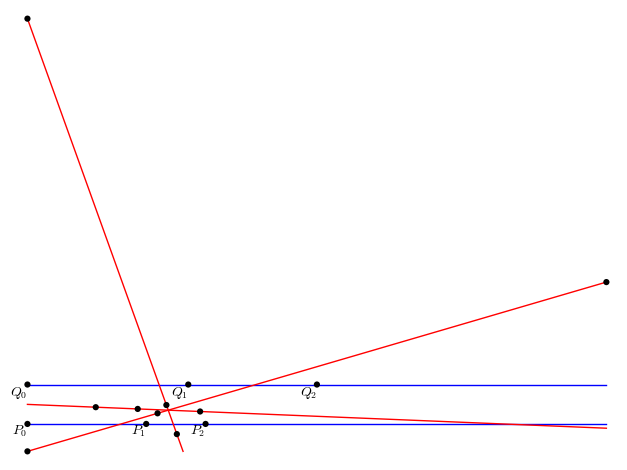

In [44]:
p = construct_triple(plane.point([0,0,1]), plane.point([2,0,1]), 2/3)
q = construct_triple(plane.point([0,2,1]), plane.point([3+1/4,2,1]), 5/9)
show(plotSteiner(p, q), axes=False)

If we apply an involution to `q`, we get the other lines:

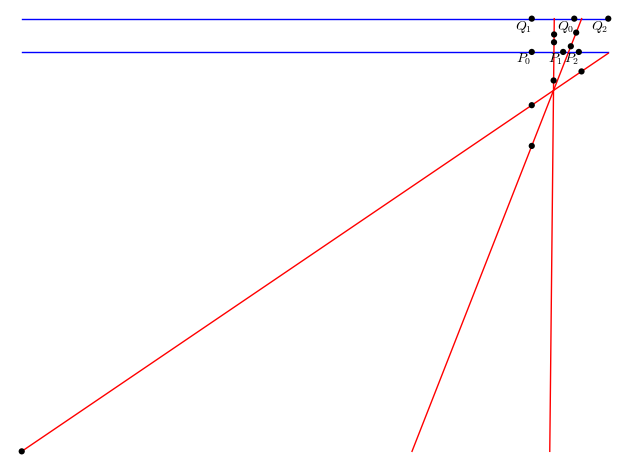

In [45]:
perm2 = Permutation('(1,2)(3)')
show(plotSteiner(p, perm2.action(q)), axes=False)

We think of Steiner's theorem telling us that we if input two triples of colinear points, then we get out two triples of coincident lines:

In [46]:
def steiner(p, q):
    even_lines = []
    odd_lines = []
    for perm in S_3:
        r = pappus(p, perm.action(q))
        l = r[0].join(r[2])
        if perm.is_even():
            even_lines.append(l)
        else:
            odd_lines.append(l)
    return even_lines, odd_lines

In [47]:
steiner(p,q)

([ProjectiveLine((-3/16, -129/128, 1)),
  ProjectiveLine((-11/18, -7/144, 1)),
  ProjectiveLine((-19/20, 23/32, 1))],
 [ProjectiveLine((-17/16, 1/128, 1)),
  ProjectiveLine((-23/36, 17/96, 1)),
  ProjectiveLine((-3/10, 5/16, 1))])

## Steiner's Theorem 2

Given two triples of colinear points, Steiner's Theorem gives two triples of concurrent lines. The output collection is ripe for an application of the dual to Steiner's Theorem, taking the two triples of concurrently lines as inputs and producing two triples of colinear points. Let us see what happens:

In [48]:
def steiner_dual(m, n):
    '''Takes as input two triples of coincident lines, produces two triples of colinear triples.'''
    p = tuple(l.dual() for l in m)
    q = tuple(l.dual() for l in n)
    m2, n2 = steiner(p, q)
    p2 = tuple(l.dual() for l in m2)
    q2 = tuple(l.dual() for l in n2)
    return p2, q2

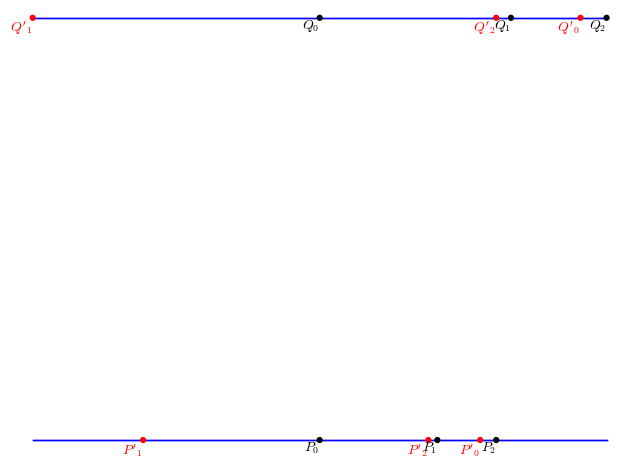

In [49]:
p = construct_triple(plane.point([0,0,1]), plane.point([2,0,1]), 2/3)
q = construct_triple(plane.point([0,2,1]), plane.point([3+1/4,2,1]), 2/3)
m,n = steiner(p,q)
p2,q2 = steiner_dual(m,n)
plt = draw_triple(p, 'P') + draw_triple(q, 'Q') + draw_triple(p2, 'P\'') + draw_triple(q2, 'Q\'')
box = PlotBox(plt)
plt = draw_triple(p, 'P', box=box) + draw_triple(q, 'Q', box=box) + \
      draw_triple(p2, 'P\'', box=box, point_opts=dict(color='red'), label_opts=dict(color='red')) + \
      draw_triple(q2, 'Q\'', box=box, point_opts=dict(color='red'), label_opts=dict(color='red'))
show(plt, axes=False)

**Steiner's Theorem 2** If you start with two triples $p$ and $q$, and apply Steiner's Theorem followed by the dual to Steiner's Theorem, you get two triples $p'$ and $q'$ on the same two lines.

**Steiner's Theorem 3** The new triple $p'$ is only depends on $p$ and the point where the lines through $p$ and $q$ intersect.

**References:**

*  J. F. Rigby, *Pappus lines and Leisenring lines,* Journal of Geometry, **21** (1983), no. 2,
108–117.
* Hooper, *[From Pappus' theorem to the twisted cubic](http://wphooper.com/docs/papers/paptwist.pdf),* Geometriae Dedicata **110** (2005), 103--134.
  

## Schwartz's Fractal Path

Richard Schwartz produced a fractal path by iterating Pappus' Theorem in a different way.

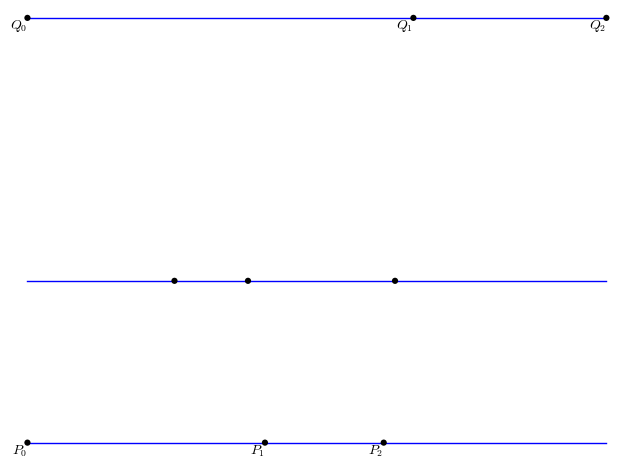

In [50]:
r = pappus(p, q)
box = None
for i in range(2):
    plt = draw_triple(p, 'P', box=box) + draw_triple(q, 'Q', box=box) + draw_triple(r, box=box)
    box = PlotBox(plt)
show(plt, axes=False)

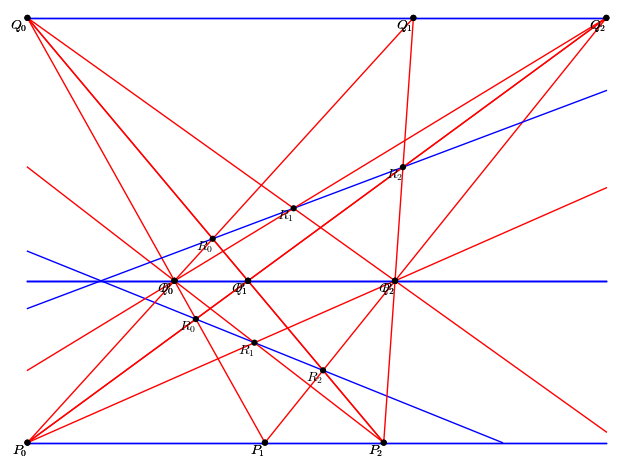

In [51]:
r = pappus(p, q)
box = None
for i in range(2):
    plt = draw_triple(p, 'P', box=box) + draw_triple(q, 'Q', box=box) + draw_triple(r, box=box)
    box = PlotBox(plt)
show(plt + draw_pappus(p, r, box=box) + draw_pappus(r, q, box=box), axes=False)

Here we construct triples recursively:

In [52]:
def construct_triple_path1(p, q, depth=1):
    r = pappus(p, q)
    if depth <= 1:
        return {p, r, q}
    else:
        return construct_triple_path1(p,r, depth-1).union(construct_triple_path1(r,q, depth-1))

In [54]:
@interact
def plot_path(depth=slider(1, 10, default=1)):
    trips = construct_triple_path1(p, q, depth=depth)
    plt = sum([draw_triple(trip) for trip in trips])
    return show(plt, axes=False)

Interactive function <function plot_path at 0x7f5e25eca660> with 1 widget
  depth: TransformIntSlider(value=1, description='depth', max=10, min=1)

In [58]:
def construct_triple_path2(p, q, epsilon=1/10):
    r = pappus(p, q)
    if (p[1].euc() - r[1].euc()).norm() > epsilon:
        trips = construct_triple_path2(p, r, epsilon=epsilon)
    else:
        trips = {p, r}
    if (r[1].euc() - q[1].euc()).norm() > epsilon:
        trips2 = construct_triple_path2(r, q, epsilon=epsilon)
    else:
        trips2 = {r, q}
    return trips.union(trips2)

In [59]:
def plot_triple_path2(p, q, epsilon=1/10):
    trips = construct_triple_path2(p, q, epsilon=epsilon)
    plt = draw_triple(p, 'P', line=False) + draw_triple(q, 'Q', line=False)
    plt += point2d([trip[1].euc() for trip in trips], size=1)
    return plt

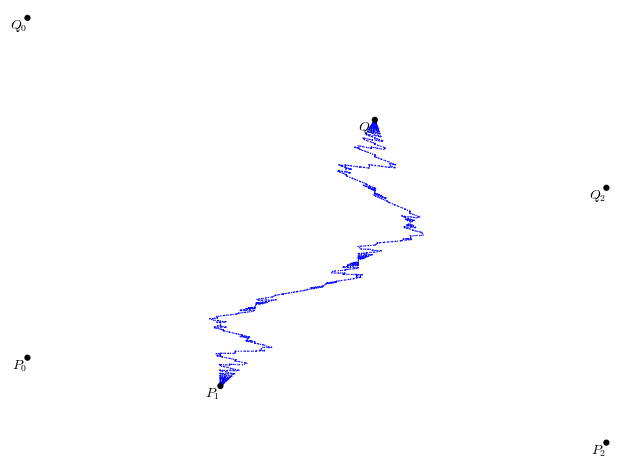

In [100]:
p = construct_triple(plane.point([0,0,1]), plane.point([2,-1/2,1]), 1/3)
q = construct_triple(plane.point([0,2,1]), plane.point([2,1,1]), 3/5)
show(plot_triple_path2(p, q, 1/100), axes=False)

Richard Schwartz extended this curve to a closed curve in the Projective Plane, and studied its symmetries:

* Richard Schwartz, *[Pappus's Theorem and the Modular Group](http://www.numdam.org/article/PMIHES_1993__78__187_0.pdf),* I.H.E.S. Publications Mathematiques (1993) Vol. 78 pp. 187-206.